<a href="https://colab.research.google.com/github/pedrosena138/assin2-bertimbau-benchmark/blob/main/ASSIN2_Portuguese_BERT_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

Install dependencies

In [3]:
# Install libs
!pip install datasets transformers evaluate huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 34.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 KB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 14.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


Huggingface Login

In [2]:
from huggingface_hub import notebook_login

notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


Git config for upload model

In [3]:
# Config git
!apt install git-lfs
!git config --global user.email "pmfsl@cin.ufpe.br"
!git config --global user.name "Pedro Sena"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git-lfs is already the newest version (2.9.2-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 27 not upgraded.


Checking if transformers lib version is gratter then 4.16.0

In [4]:
import transformers

assert transformers.__version__ > '4.16.0'
print(transformers.__version__)

4.26.0


In [6]:
def check_model(model_name):
    if not model_name:
        raise Exception('Model name not informed')
    if model_name not in MODELS.keys():
        raise Exception("Invalid model name. Please check options in MODELS variable")
    return

In [1]:
import random
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from transformers.keras_callbacks import KerasMetricCallback, PushToHubCallback
from datasets import load_dataset
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, create_optimizer, pipeline
import evaluate

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import display, HTML

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [8]:
num_gpus_available = len(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", num_gpus_available)

Num GPUs Available:  1


In [3]:
# Plot style
mpl.rcParams['figure.figsize'] = (14, 12)
plt.style.use('seaborn')

BATCH_SIZE = 16
NUM_EPOCHS = 5

#Options: stsb, rte
TASK =  'rte'
MODELS = {
    "b-base": "neuralmind/bert-base-portuguese-cased",
    "b-large": "neuralmind/bert-large-portuguese-cased",
    "multi": "bert-base-multilingual-cased",
    "xr-base": "xlm-roberta-base",
    "xr-large": "xlm-roberta-large"
}

# ASSIN2 Dataset

In [2]:
ASSIN2_TASKS = [
    'rte',
    'stsb'
]

def check_task():
    if not TASK:
        raise Exception('Task not informed')
    if TASK not in ASSIN2_TASKS:
        raise Exception("Invalid task value. Choose 'sts' or 'rte'")
    return

In [4]:
dataset = load_dataset('assin2')

Generating train split:   0%|          | 0/6500 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2448 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset assin2 downloaded and prepared to /root/.cache/huggingface/datasets/assin2/default/1.0.0/8467f7acbda82f62ab960ca869dc1e96350e0e103a1ef7eaa43bbee530b80061. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [5]:
dataset['train'][0]

{'sentence_pair_id': 1,
 'premise': 'Uma criança risonha está segurando uma pistola de água e sendo espirrada com água',
 'hypothesis': 'Uma criança está segurando uma pistola de água',
 'relatedness_score': 4.5,
 'entailment_judgment': 1}

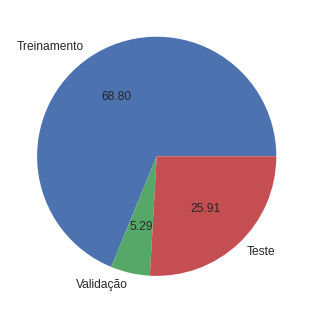

In [6]:
train_size = dataset['train'].num_rows
val_size = dataset['validation'].num_rows
test_size = dataset['test'].num_rows

plt.pie([train_size, val_size, test_size], labels=['Treinamento', 'Validação', 'Teste'], autopct='%.2f', textprops={'size': 'large'})
plt.show()

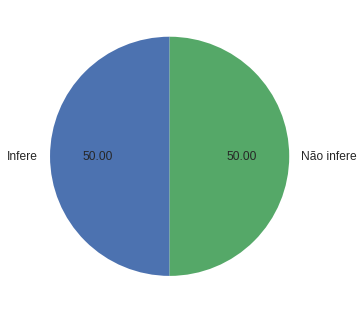

In [7]:
def count_pos_and_neg():
    pos = 0,
    neg = 0
    for key in dataset.keys():
        partial_neg, partial_pos = np.bincount(dataset[key]['entailment_judgment'])
        pos += partial_pos
        neg += int(partial_neg)

    return int(pos), neg

pos, neg = count_pos_and_neg()
plt.pie([pos, neg], labels=['Infere', 'Não infere'], autopct='%.2f', textprops={'size': 'large'}, startangle=90)
plt.show()

# Pre-processamento

In [8]:
def get_relatedness_scores():
    scores = []
    for key in dataset.keys():
        scores.extend(dataset[key]['relatedness_score'])
    return np.array(scores)

def encoder(examples):
    return tokenizer(
        examples['premise'],
        examples['hypothesis'],
        truncation=True)
    
def normalize_relatedness_score(examples):
    scores = np.array(examples['relatedness_score'])
    return {'label': scaler.transform(scores.reshape(-1, 1)).reshape(1, -1)[0]}

In [16]:
model_name = 'b-base'
check_model(model_name)

tokenizer = AutoTokenizer.from_pretrained(MODELS[model_name], model_max_length=train_size)

encoded_dataset = dataset.map(encoder, batched=True)

check_task()
if TASK == 'stsb':
    # Normalize relatedness scores
    # scaler = MinMaxScaler()
    # scores = get_related_scores()
    # scaler.fit(scores.reshape(-1, 1))
    # encoded_dataset = encoded_dataset.map(normalize_relatedness_score, batched=True)
    encoded_dataset = encoded_dataset.map(lambda x: {'label': x['entailment_judgment']}, batched=True)
else:
    encoded_dataset = encoded_dataset.map(lambda x: {'label': x['entailment_judgment']}, batched=True)

pre_encoder_columns = set(dataset["train"].features)
encoder_columns = list(set(encoded_dataset["train"].features) - pre_encoder_columns)

print("\nColumns added after preprocessing:", encoder_columns)

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/3 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]


Columns added after preprocessing: ['token_type_ids', 'label', 'input_ids', 'attention_mask']


# Fine-tuning

In [38]:
if TASK == 'stsb':
    metric = evaluate.load('pearsonr')
else:
    metric = evaluate.combine(['accuracy', 'f1'])

def compute_metrics(eval_predictions):
    predictions, labels = eval_predictions
    if TASK == "stsb":
        predictions = predictions[:, 0]
    else:
        predictions = np.argmax(predictions, axis=1)

    return metric.compute(predictions=predictions, references=labels)

In [18]:
def load_model(model_name, total_train_steps):
    from_pt = True if model_name == MODELS["b-large"] else False
    optimizer, schedule = create_optimizer(
        init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps
    )

    if TASK == 'stsb':
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name, num_labels=1, from_pt=from_pt)
        model.compile(
            optimizer=optimizer,
            loss='mse'
        )
    elif TASK == 'rte':
        id2label = {0: "None", 1: "Entails"}
        label2id = {"None": 0, "Entails": 1}
        
        model = TFAutoModelForSequenceClassification.from_pretrained(model_name,
                                          num_labels=2,
                                          id2label=id2label, 
                                          label2id=label2id,
                                          from_pt=from_pt)   
        model.compile(
                optimizer=optimizer,
        )
            
    return model

In [20]:
batches_per_epoch = train_size // BATCH_SIZE
total_train_steps = int(batches_per_epoch * NUM_EPOCHS)

model = load_model(MODELS[model_name], total_train_steps)
model.summary()

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier', 'bert/pooler/dense/kernel:0', 'bert/pooler/dense/bias:0']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108923136 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 108,924,674
Trainable params: 108,924,674
Non-trainable params: 0
_________________________________________________________________


In [37]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_set = model.prepare_tf_dataset(
    encoded_dataset["train"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

tf_validation_set = model.prepare_tf_dataset(
    encoded_dataset["validation"],
    shuffle=True,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    encoded_dataset["test"],
    shuffle=False,
    batch_size=BATCH_SIZE,
    collate_fn=data_collator,
)

In [24]:
metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics, eval_dataset=tf_validation_set
)

model_checkpoint = MODELS[model_name].split("/")[-1]
push_to_hub_model_id = f"{model_checkpoint}-finetuned-{TASK}-assin2"

tensorboard_callback = TensorBoard(log_dir=f"./{push_to_hub_model_id}/logs")

push_to_hub_callback = PushToHubCallback(
    output_dir=f"./{push_to_hub_model_id}",
    tokenizer=tokenizer,
    hub_model_id=push_to_hub_model_id,
)

callbacks = [metric_callback, tensorboard_callback, push_to_hub_callback]

print(f'\nTask: {TASK}')
print(f'Model: {push_to_hub_model_id}')
history = model.fit(x=tf_train_set, validation_data=tf_validation_set, epochs=NUM_EPOCHS, callbacks=callbacks)

/content/bert-base-portuguese-cased-finetuned-rte-assin2 is already a clone of https://huggingface.co/pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2. Make sure you pull the latest changes with `repo.git_pull()`.



Task: rte
Model: bert-base-portuguese-cased-finetuned-rte-assin2
Epoch 1/5
  6/406 [..............................] - ETA: 1:03 - loss: 0.7026

406/406 [==============================] - 115s 223ms/step - loss: 0.3693 - val_loss: 0.1806 - accuracy: 0.9294 - f1: 0.9301
Epoch 2/5
406/406 [==============================] - 99s 244ms/step - loss: 0.1818 - val_loss: 0.1572 - accuracy: 0.9375 - f1: 0.9393
Epoch 3/5
406/406 [==============================] - 100s 246ms/step - loss: 0.0987 - val_loss: 0.1465 - accuracy: 0.9516 - f1: 0.9524
Epoch 4/5
406/406 [==============================] - 101s 249ms/step - loss: 0.0790 - val_loss: 0.1462 - accuracy: 0.9516 - f1: 0.9522
Epoch 5/5
406/406 [==============================] - 101s 249ms/step - loss: 0.0803 - val_loss: 0.1464 - accuracy: 0.9536 - f1: 0.9543


In [33]:
def plot_loss(history, label='Loss'):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'], label='Val ' + label)
  
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Loss', fontsize=16)
  plt.legend()

def plot_metrics(history, metrics):
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric])
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    else:
      plt.ylim([0,1])

    plt.legend();

def plot_confusion_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions)
  plt.figure(figsize=(8,8))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('True Negatives:', cm[0][0])
  print('False Positives:', cm[0][1])
  print('False Negatives:', cm[1][0])
  print('True Positives:', cm[1][1])

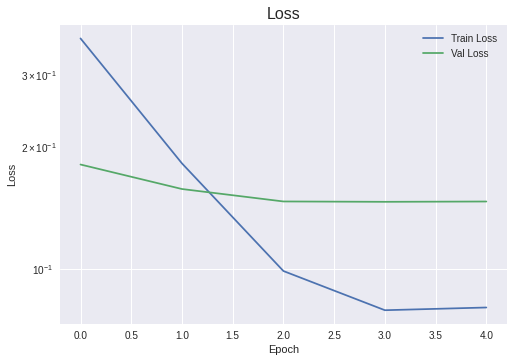

In [26]:
plot_loss(history)

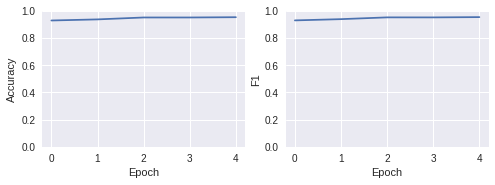

In [29]:
del history.history['loss']
del history.history['val_loss']

plot_metrics(history, metrics=history.history.keys())

In [32]:
results = model.evaluate(tf_test_set, callbacks=callbacks)

153/153 [==============================] - 12s 78ms/step - loss: 0.3844


In [33]:
results

0.38438454270362854

In [10]:
model = TFAutoModelForSequenceClassification.from_pretrained("pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2")
tokenizer = AutoTokenizer.from_pretrained("pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2")
classifier = pipeline("text-classification", "pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2", framework="tf")

Some layers from the model checkpoint at pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2 were not used when initializing TFBertForSequenceClassification: ['dropout_37']
- This IS expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertForSequenceClassification were initialized from the model checkpoint at pmfsl/bert-base-portuguese-cased-finetuned-rte-assin2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForSequenceClassification for predictions without further training.
Som

In [28]:
sentences = []
for d in dataset['test']:
    text = '{}. {}'.format(d['premise'], d['hypothesis'])
    sentences.append(text)

In [19]:
outputs = classifier(sentences)

In [39]:
label_col = 'relatedness_score' if TASK == 'stsb' else 'entailment_judgment'
label2id = {"None": 0, "Entails": 1}
y = dataset['test'][label_col]
y_hat = [label2id[d['label']] for d in outputs]

metric.compute(predictions=y_hat, references=y)

{'accuracy': 0.610702614379085, 'f1': 0.3894939141575912}

True Negatives: 1191
False Positives: 33
False Negatives: 920
True Positives: 304


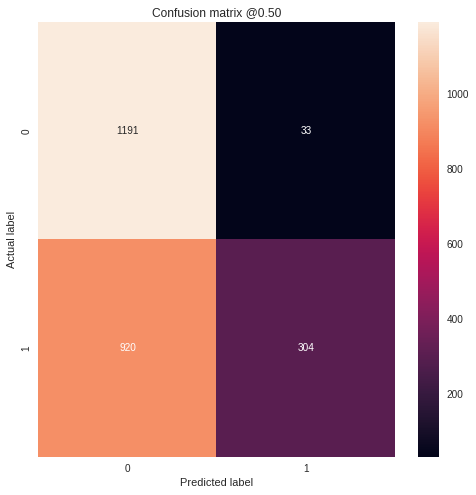

In [36]:
plot_confusion_matrix(y, y_hat)

In [43]:
d = pd.DataFrame(outputs)
d.to_csv('pt_bert_rte_preds.csv')